In [5]:
%load_ext autoreload
%autoreload 2
main_dir = r'f:\Projects\Prvate\Baydin'

data_path = r'E:/Kaggle/05-LabelEncoded-last'
import sys
sys.path.append(main_dir)
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union

from BayDS.lib.pipeline import *
from BayDS.lib.io import *

import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Code to make pipeline node

In [6]:
data = pd.read_pickle(f'{data_path}/label_encoded_data.pkl')

In [7]:
X = data[data.isFraud>=0].drop('isFraud',axis=1)
test = data[data.isFraud<0].drop('isFraud',axis=1)
y= data[data.isFraud>=0].isFraud

In [9]:
import yaml
categorical_features = yaml.load(open(f'{data_path}/categorical_columns.yaml','r'))
numerical_features = yaml.load(open(f'{data_path}/numerical_columns.yaml','r'))
bad_features = yaml.load(open(f'{data_path}/bad_for_training_features.yaml','r'))

categorical_features = [f for f in categorical_features if f not in bad_features]
all_features =  [f for f in X.columns if f not in bad_features]

In [10]:
from BayDS.lib.training import *

Using TensorFlow backend.
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as

In [13]:
drop_big_categorical_features = []
for col in categorical_features:
    if len(data[col].value_counts()) > 50:
        drop_big_categorical_features.append(col)
        print(col, len(data[col].value_counts()))

card_id 19226
new_card_id 144827
OSVersion 88
device_version 380
BrowserVersion 54
id_13 56
id_17 128
id_19 569
id_20 548
id_21 735
id_25 441
id_26 116
id_30 88
id_31 173
id_33 462
DeviceInfo 2800
P_emaildomain 61
R_emaildomain 61
card1 9118
card2 497
card3 97
card5 84
addr1 442
addr2 94
device_version 380
id_02__id_20 270750
id_02__D8 258079
D11__DeviceInfo 3680
DeviceInfo__P_emaildomain 8978
P_emaildomain__C2 6793
card2__dist1 31408
card1__card5 18808
card2__id_20 9240
card5__P_emaildomain 1574
addr1__card1 55370
uid 11014
uid2 11442
uid3 52025
uid4 129426
uid5 91344
bank_type 726
product_type 30362


In [14]:
# X.drop(features_to_drop,axis=1,inplace=True)
# test.drop(features_to_drop,axis=1,inplace=True)
use_for_train_features =  [f for f in all_features if f not in drop_big_categorical_features]

In [15]:
categorical_features =  [f for f in categorical_features if f not in drop_big_categorical_features]

In [23]:
for col in X.columns:
    if str(X[col].dtype) == 'datetime64[ns]':
        print (col, X[col].dtype)
        X[col] = pd.to_timedelta(X[col]).map(lambda qq:qq.days)
        test[col] = pd.to_timedelta(test[col]).map(lambda qq:qq.days)
#         X[col] = X[col].astype(datetime.datetime)

Date datetime64[ns]
start_date datetime64[ns]


In [8]:
from sklearn.model_selection import GroupKFold

NFOLDS = 6
folds = GroupKFold(n_splits=NFOLDS)


In [20]:
params = {
          'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 10,
          'learning_rate': 0.003,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 500,
        'n_estimators': 10000,
        'averaging': 'usual',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

Fold 1 started at Mon Sep 30 11:17:01 2019
Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 0.914474	training's auc: 0.914473	valid_1's auc: 0.85591	valid_1's auc: 0.855912
[200]	training's auc: 0.928595	training's auc: 0.928595	valid_1's auc: 0.866185	valid_1's auc: 0.866185
[300]	training's auc: 0.938065	training's auc: 0.938065	valid_1's auc: 0.872388	valid_1's auc: 0.872388
[400]	training's auc: 0.945859	training's auc: 0.945859	valid_1's auc: 0.876922	valid_1's auc: 0.876922
[500]	training's auc: 0.952242	training's auc: 0.952242	valid_1's auc: 0.880587	valid_1's auc: 0.880587
[600]	training's auc: 0.957344	training's auc: 0.957344	valid_1's auc: 0.883827	valid_1's auc: 0.883827
[700]	training's auc: 0.961987	training's auc: 0.961987	valid_1's auc: 0.886254	valid_1's auc: 0.886254
[800]	training's auc: 0.965878	training's auc: 0.965878	valid_1's auc: 0.888744	valid_1's auc: 0.888744
[900]	training's auc: 0.969224	training's auc: 0.969224	valid_1

[1000]	training's auc: 0.970881	training's auc: 0.970881	valid_1's auc: 0.922227	valid_1's auc: 0.922227
[1100]	training's auc: 0.973317	training's auc: 0.973317	valid_1's auc: 0.9237	valid_1's auc: 0.9237
[1200]	training's auc: 0.975252	training's auc: 0.975252	valid_1's auc: 0.924923	valid_1's auc: 0.924923
[1300]	training's auc: 0.976626	training's auc: 0.976626	valid_1's auc: 0.925861	valid_1's auc: 0.925861
[1400]	training's auc: 0.977829	training's auc: 0.977829	valid_1's auc: 0.926707	valid_1's auc: 0.926707
[1500]	training's auc: 0.978777	training's auc: 0.978777	valid_1's auc: 0.927379	valid_1's auc: 0.927379
[1600]	training's auc: 0.979573	training's auc: 0.979573	valid_1's auc: 0.928002	valid_1's auc: 0.928002
[1700]	training's auc: 0.980298	training's auc: 0.980298	valid_1's auc: 0.928507	valid_1's auc: 0.928507
[1800]	training's auc: 0.981051	training's auc: 0.981051	valid_1's auc: 0.929002	valid_1's auc: 0.929002
[1900]	training's auc: 0.981828	training's auc: 0.981828	va

[1300]	training's auc: 0.975587	training's auc: 0.975587	valid_1's auc: 0.927769	valid_1's auc: 0.927769
[1400]	training's auc: 0.976881	training's auc: 0.976881	valid_1's auc: 0.928789	valid_1's auc: 0.928789
[1500]	training's auc: 0.977925	training's auc: 0.977925	valid_1's auc: 0.929765	valid_1's auc: 0.929765
[1600]	training's auc: 0.978881	training's auc: 0.978881	valid_1's auc: 0.930576	valid_1's auc: 0.930576
[1700]	training's auc: 0.979653	training's auc: 0.979653	valid_1's auc: 0.931256	valid_1's auc: 0.931256
[1800]	training's auc: 0.980532	training's auc: 0.980532	valid_1's auc: 0.931904	valid_1's auc: 0.931904
[1900]	training's auc: 0.981237	training's auc: 0.981237	valid_1's auc: 0.932473	valid_1's auc: 0.932473
[2000]	training's auc: 0.981914	training's auc: 0.981914	valid_1's auc: 0.932986	valid_1's auc: 0.932986
[2100]	training's auc: 0.982636	training's auc: 0.982636	valid_1's auc: 0.933507	valid_1's auc: 0.933507
[2200]	training's auc: 0.98324	training's auc: 0.98324	

[9200]	training's auc: 0.999239	training's auc: 0.999239	valid_1's auc: 0.943987	valid_1's auc: 0.943987
[9300]	training's auc: 0.999274	training's auc: 0.999274	valid_1's auc: 0.943955	valid_1's auc: 0.943955
[9400]	training's auc: 0.999306	training's auc: 0.999306	valid_1's auc: 0.943968	valid_1's auc: 0.943968
[9500]	training's auc: 0.999334	training's auc: 0.999334	valid_1's auc: 0.943946	valid_1's auc: 0.943946
[9600]	training's auc: 0.999368	training's auc: 0.999368	valid_1's auc: 0.943963	valid_1's auc: 0.943963
Early stopping, best iteration is:
[9158]	training's auc: 0.99922	training's auc: 0.99922	valid_1's auc: 0.943999	valid_1's auc: 0.943999
Fold 4 started at Mon Sep 30 14:04:32 2019
Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 0.910911	training's auc: 0.91091	valid_1's auc: 0.880544	valid_1's auc: 0.880544
[200]	training's auc: 0.926301	training's auc: 0.926301	valid_1's auc: 0.889998	valid_1's auc: 0.889998
[300]	training's auc: 0.

[7300]	training's auc: 0.998381	training's auc: 0.998381	valid_1's auc: 0.936694	valid_1's auc: 0.936694
Early stopping, best iteration is:
[6874]	training's auc: 0.997987	training's auc: 0.997987	valid_1's auc: 0.936759	valid_1's auc: 0.936759
Fold 5 started at Mon Sep 30 14:57:20 2019
Training until validation scores don't improve for 500 rounds.
[100]	training's auc: 0.909749	training's auc: 0.90975	valid_1's auc: 0.903514	valid_1's auc: 0.903515
[200]	training's auc: 0.923448	training's auc: 0.923448	valid_1's auc: 0.911672	valid_1's auc: 0.911672
[300]	training's auc: 0.934048	training's auc: 0.934048	valid_1's auc: 0.918863	valid_1's auc: 0.918863
[400]	training's auc: 0.941777	training's auc: 0.941777	valid_1's auc: 0.923155	valid_1's auc: 0.923155
[500]	training's auc: 0.948163	training's auc: 0.948163	valid_1's auc: 0.926924	valid_1's auc: 0.926924
[600]	training's auc: 0.954011	training's auc: 0.954011	valid_1's auc: 0.930226	valid_1's auc: 0.930226
[700]	training's auc: 0.95

[700]	training's auc: 0.959828	training's auc: 0.959828	valid_1's auc: 0.920405	valid_1's auc: 0.920405
[800]	training's auc: 0.963306	training's auc: 0.963306	valid_1's auc: 0.923042	valid_1's auc: 0.923042
[900]	training's auc: 0.966657	training's auc: 0.966657	valid_1's auc: 0.925381	valid_1's auc: 0.925381
[1000]	training's auc: 0.96948	training's auc: 0.96948	valid_1's auc: 0.927275	valid_1's auc: 0.927275
[1100]	training's auc: 0.972007	training's auc: 0.972007	valid_1's auc: 0.929006	valid_1's auc: 0.929006
[1200]	training's auc: 0.973756	training's auc: 0.973756	valid_1's auc: 0.930322	valid_1's auc: 0.930322
[1300]	training's auc: 0.975172	training's auc: 0.975172	valid_1's auc: 0.931473	valid_1's auc: 0.931473
[1400]	training's auc: 0.97634	training's auc: 0.97634	valid_1's auc: 0.932346	valid_1's auc: 0.932346
[1500]	training's auc: 0.977371	training's auc: 0.977371	valid_1's auc: 0.93334	valid_1's auc: 0.93334
[1600]	training's auc: 0.978366	training's auc: 0.978366	valid_1

[8600]	training's auc: 0.998914	training's auc: 0.998914	valid_1's auc: 0.950681	valid_1's auc: 0.950681
[8700]	training's auc: 0.998973	training's auc: 0.998973	valid_1's auc: 0.950674	valid_1's auc: 0.950674
[8800]	training's auc: 0.99903	training's auc: 0.99903	valid_1's auc: 0.950676	valid_1's auc: 0.950676
[8900]	training's auc: 0.999089	training's auc: 0.999089	valid_1's auc: 0.950662	valid_1's auc: 0.950662
[9000]	training's auc: 0.999137	training's auc: 0.999137	valid_1's auc: 0.95066	valid_1's auc: 0.95066
Early stopping, best iteration is:
[8574]	training's auc: 0.998901	training's auc: 0.998901	valid_1's auc: 0.950691	valid_1's auc: 0.950691
CV mean score: 0.9386, std: 0.0128.


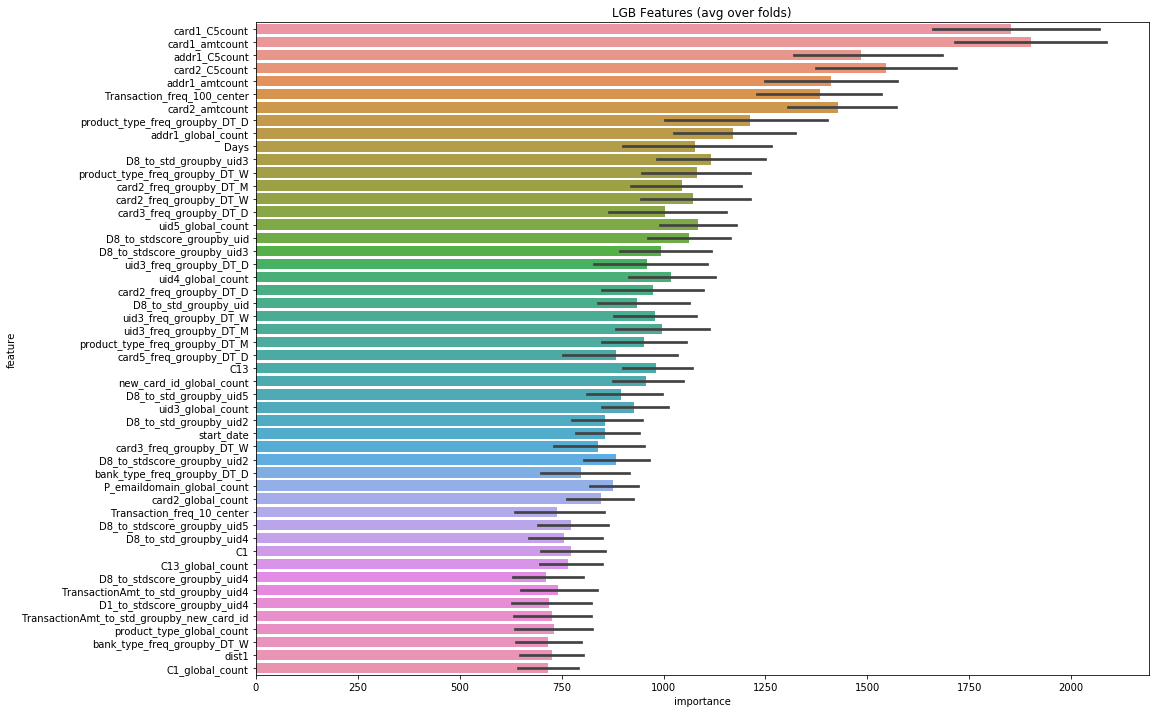

In [24]:
result_dict = train_model_classification_vb(X=X, X_test=test, columns=use_for_train_features,
                                             y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             categorial_columns = categorical_features,
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=X['DT_M'])


In [26]:
import pickle
pickle.dump(result_dict,open(f'{data_path}/results_dict_lightgbm-work-1.pkl','wb'))

In [28]:
pd.DataFrame(result_dict['oof'], columns=['isFraud'], index=X.index).to_csv(f'{data_path}/oof_lightgbm-work-1.csv')

pd.DataFrame(result_dict['prediction'], columns=['isFraud'], index=test.index).to_csv(f'{data_path}/prediction_lightgbm-work-1.csv')

sample_submission = pd.read_csv(data_path + '/sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_dict['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv(f'{data_path}/lightgbm-work-1_sub.csv')

FileNotFoundError: [Errno 2] File b'E:/Kaggle/05-LabelEncoded-last/sample_submission.csv' does not exist: b'E:/Kaggle/05-LabelEncoded-last/sample_submission.csv'